The task is to create the quantum walk operator for the following graph in Classiq SDK:

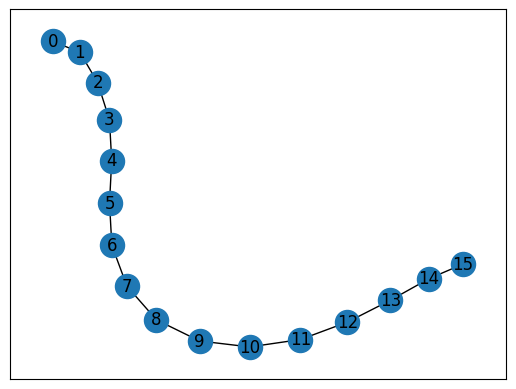

In [1]:
import networkx as nx

pairs = [(i, i+1) for i in range(16-1)]
G = nx.Graph()
G.add_nodes_from(range(16))
G.add_edges_from(list(pairs))

nx.draw_networkx(G)

In the reference example available [here](https://github.com/Classiq/classiq-library/blob/main/community/womanium/assignments/quantum_walk_circle_example.py), except for the parts where probabilities are defined to implement 'W_iteration' and the 'edge_oracle' function, the code is generic (independent of the graph). These two parts are modified appropriately for the given graph and the detailed descriptions of these changes are mentioned below.

In [2]:
# !pip install -U classiq

In [3]:
# import classiq
# classiq.authenticate()

In [4]:
from classiq import *

Since the given graph has $16$ vertices, $4$ qubits are required to encode them which is stored in the variable 'size' and the vertices are encoded in the $2^4=16$ (standard) basis vectors.

In [5]:
size = 4

@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum], x: QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

For a fixed vertex, the probability vector is defined by taking an equal superposition of the states of the adjacent vertices. Clearly, the $0$-th vertex is only adjacent to the $1$-st vertex and the $15$-th vertex is adjacent to the $14$-th vertex. So, the probability vectors for these two vertices have only one nonzero entry $1$ at the $1$-st and $14$-th places respectively. All the intermediate vertices have two adjacent vertices (namely, $i-1$ and $i+1$ for the $i$-th vertex). So, the probability vectors have two nonzero entries $0.5$ at those two places.

In [6]:
def probs(i):
    plist = [0] * (2**size)
    if i==0:
      plist[i+1]=1
    elif i==2**size - 1:
      plist[i-1]=1
    else:
      plist[i+1]=0.5
      plist[i-1]=0.5
    return plist

In [7]:
def W_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = probs(i)
    print(f'State={i}, prob vec ={prob}')

    control(ctrl= vertices==i, operand= lambda: within_apply(
        compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
        action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def W_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration(i, vertices, adjacent_vertices)

The 'edge_oracle' function is defined to return the value $1$ as 'res' if two vertices are adjacent to each other and zero otherwise. For the given graph, it is easy to observe that two vertices are adjacent if and only if the difference of the vertex numbers is $1$, that is, either 'vertices' $-$ 'adjacent_vertices' is $1$ or $-1$.

In [8]:
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= ((vertices - adjacent_vertices) == (1 or -1))

In [9]:
@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
  repeat(count= x.len, iteration= lambda i: SWAP(x[i],y[i]))


@qfunc
def S_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl= res==1,
            operand= lambda: bitwise_swap(vertices, adjacent_vertices))

In [10]:
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):

  allocate(size, vertices)
  hadamard_transform(vertices)
  allocate(size, adjacent_vertices)

  W_operator(vertices, adjacent_vertices)
  S_operator(vertices, adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

The desired implementation is available in the above link of Classiq.